<img src="./img/oscon.png" width="400">

# Abstraction layers 

# contrib.learn

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib import cm
import itertools
import numpy as np

# Estimators
### 1. Instantiate the Estimator class
~~~python 
model = learn.Estimator()
~~~
### 2.  Fit it using training data
~~~python 
model.fit()
~~~
### 3. Evaluate how good is the fit
~~~python 
model.evaluate()
~~~
### 4. Predict outcomes on new data
~~~python 
model.predict()
~~~



# Deep Neural Network Estimator

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib import layers
learn = tf.contrib.learn
import numpy as np
import time

tf.logging.set_verbosity(tf.logging.ERROR)

DATA_DIR = '/tmp/data'
data = input_data.read_data_sets(DATA_DIR, one_hot=False)
x_data, y_data = data.train.images,data.train.labels.astype(np.int32)
x_test, y_test = data.test.images,data.test.labels.astype(np.int32)
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=10)]

# Or estimator using the ProximalAdagradOptimizer optimizer with
# regularization.


estimator = learn.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[200],
    n_classes=10,
    optimizer=tf.train.ProximalAdagradOptimizer(
      learning_rate=0.2,
    ))

fit = estimator.fit(x=x_data,y=y_data, steps=2000,batch_size=128)
print('Done fitting')

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Done fitting


In [8]:
ev = estimator.evaluate(x=x_test,y=y_test, steps=1)["accuracy"]
print ev

0.9776


 <tr>
    <td> <img src="./img/mnist-digits-small.png"  width="400"/> </td>
    <td> <img src="./img/acc_vs_n_units.png"  width="600"/> </td>
    </tr>

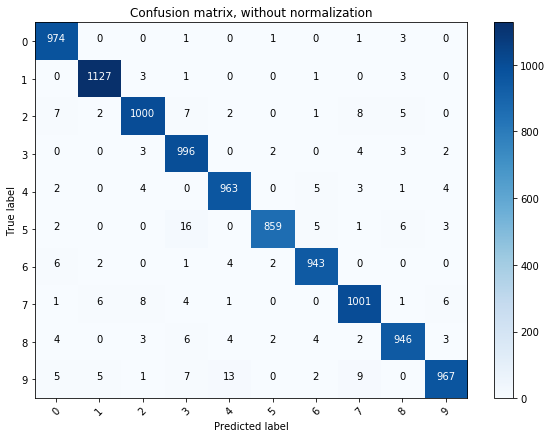

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap,aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

y_pred = estimator.predict(x=x_test,as_iterable=False)
class_names = ['0','1','2','3','4','5','6','7','8','9']    
    
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure(figsize=[8,6])
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')




# Creating a custom Estimator
## Logistic regression:

# $$Pr(y_i=1|x_i)={1\over{1+\exp^{wx_i+b}} }$$

In [ ]:
learn = tf.contrib.learn

import numpy as np
N = 10000

# generate data
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
# === Create data and simulate results =====
x_data = np.random.randn(N,3)
w_real = [0.3,0.5,0.1]
b_real = -0.2
wxb = np.matmul(w_real,x_data.T) + b_real

y_data_pre_noise = sigmoid(wxb)
y_data = np.random.binomial(1,y_data_pre_noise)

# Model function

We construct a model function where our homemade network will reside, and also an object containing our training settings.

In [ ]:
def my_model_fn(x_data,y_data,mode,params):

    with tf.name_scope('inference') as scope:
        w = tf.Variable([[0,0,0]],dtype=tf.float32,name='weights')
        b = tf.Variable(0,dtype=tf.float32,name='bias')
        y_pred = tf.matmul(w,tf.transpose(x_data)) + b

    with tf.name_scope('loss') as scope:
        y_data = tf.expand_dims(y_data,0)
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_data,logits=y_pred) 
        loss = tf.reduce_mean(loss)

    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.contrib.framework.get_global_step(),
        learning_rate=params["learning_rate"],
        optimizer="Adagrad")
    
    return y_pred, loss, train_op

# Input function and Feature column

Encapsulating the pre-proccessing of the data as a function is required by contrib.learn, as we will see shortly. 

The function gets both predictors and target data in their native form (pandas data frame, numpy array, list etc.) as input, and returns a dictionary of tensors. In these dictionaries, each key is a name of a FeatureColumn 

This means that we also have to transform the values into a TensorFlow Tensor inside the function.

## Feature column

With FeatureColumn we can maintain representation of a single feature in our data, while performing a range of transformations defined over it —a feature column can be either one of the original columns, or any new columns, depending on our transformations.All while manipulating the feature as a single semantic unit (encompassing, for example, all dummy vectors).

We use the FeatureColumn function to specify the form and structure of each feature of our input data. 

In [ ]:
def input_fn(x_data,y_data):
        
    feature_cols = {}
    feature_cols['x_data'] = tf.constant(x_data,dtype=tf.float32)    
    labels = tf.constant(y_data,dtype=tf.float32)
    
    x = tf.contrib.layers.real_valued_column('x_data')
    
    feature_cols = tf.contrib.layers.input_from_feature_columns(
    columns_to_tensors=feature_cols, feature_columns=[x])
    
    return feature_cols, labels

### feature_engineering

In [51]:
def feature_engineering_fn(feature_cols, labels):
    "Do some prepreocessing here"
    return feature_cols, labels

In [57]:
model_params = {"learning_rate": 0.5}
est = learn.Estimator(model_fn=my_model_fn,\
                      feature_engineering_fn=feature_engineering_fn,\
                      params=model_params,\
                      model_dir='tmp/',\
                      config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1))
fit = est.fit(input_fn=lambda:input_fn(x_data,y_data),steps=50)

In [53]:
print est.get_variable_names()

['OptimizeLoss/inference/bias/Adagrad', 'OptimizeLoss/inference/weights/Adagrad', 'OptimizeLoss/learning_rate', 'global_step', 'inference/bias', 'inference/weights']


In [54]:
w_w = est.get_variable_value('inference/weights')
print 'Estimation for weights: {}'.format(w_w)

Estimation for weights: [[ 0.28  0.49  0.12]]


In [55]:
b = est.get_variable_value('inference/bias')
print 'Estimation for bias: {}'.format(b)

Estimation for bias: -0.18423640728


## Logistic regression with categories:

# $$Pr(y_i=1|x_i)={1\over{1+\exp^{wx_i+c_i}} }$$

In [2]:
N = 10000

# generate data

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# === Create data and simulate results =====
x_data = np.random.randn(N,3)
w_real = [0.3,0.5,0.1]
bias = [-1.2,0,1.2]

category_id = np.random.randint(0,3,N)


noise = np.random.randn(1,N)*0.1
wx = np.matmul(w_real,x_data.T) 
wxb = np.array([wx[i]+bias[b]for i,b in enumerate(category_id)])

category_names = ['computers','food','clothes']
category = np.array([category_names[s] for s in category_id])

y_data_pre_noise = sigmoid(wxb)
y_data = np.random.binomial(1,y_data_pre_noise)

<img src="./img/logistic_with_cat.png" width="700">

In [3]:
import pandas as pd
df = pd.DataFrame({'bias':category,'x1':x_data[:,0],'x2':x_data[:,1],'x3':x_data[:,2],'target':y_data})
cols = df.columns.tolist()
cols = [cols[2],cols[3],cols[4],cols[0],cols[1]]
df = df[cols]
df[:9]

,x1,x2,x3,bias,target
0,-1.364387,-1.617093,0.209451,food,0
1,-1.426549,0.964208,0.046782,computers,1
2,-0.124590,-0.143190,-0.231905,computers,1
3,0.923523,-0.288710,1.743290,computers,1
4,1.565638,0.510525,1.851231,clothes,0
5,-0.357661,-0.191030,0.194708,food,0
6,0.558920,1.368179,0.338781,clothes,1
7,-0.127846,0.344887,-1.560178,computers,0
8,-0.750513,-0.256467,-0.862158,food,0


In [ ]:
def my_model_fn(feature_cols,y_data,mode,params):


    with tf.name_scope('inference') as scope:
        w_x = tf.Variable([[0,0,0]],dtype=tf.float32,name='w_x')
        w_cat = tf.Variable([[0,0,0]],dtype=tf.float32,name='w_cat')
        b = tf.Variable(0,dtype=tf.float32,name='b')
        y_pred = tf.matmul(w_cat,tf.transpose(feature_cols[:,:3]))+\
                             tf.matmul(w_x,tf.transpose(feature_cols[:,3:]))

    with tf.name_scope('loss') as scope:
        y_data = tf.expand_dims(y_data,0)
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_data,logits=y_pred) 
        loss = tf.reduce_mean(loss)
     
    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.contrib.framework.get_global_step(),
        learning_rate=params["learning_rate"],
        optimizer="Adagrad")
    
    return y_pred, loss, train_op

In [ ]:
# Input builders
def input_fn(x_data,category,y_data):
        
    feature_cols = {}
    feature_cols['x_data'] = tf.constant(x_data,dtype=tf.float32)    
    x = tf.contrib.layers.real_valued_column('x_data')

    labels = tf.constant(y_data,dtype=tf.float32)
    
    feature_cols['category'] = tf.SparseTensor(
    indices=[[i, 0] for i in range(category.size)],
    values=category, dense_shape=[category.size, 1])
    
    # see what's the order
    print list(feature_cols)
    
    cat=tf.contrib.layers.sparse_column_with_keys(
    column_name='category', keys=category_names)
    
    cat = tf.contrib.layers.one_hot_column(cat)
    
    feature_cols = tf.contrib.layers.input_from_feature_columns(
    columns_to_tensors=feature_cols, feature_columns=[x,cat])
    
    return feature_cols, labels


In [19]:
tf.logging.set_verbosity(tf.logging.ERROR)

model_params = {"learning_rate": 0.5}
est = learn.Estimator(model_fn=my_model_fn,\
                      params=model_params,\
                      config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1))
#                       model_dir='tmp/',\

est.fit(input_fn=lambda:input_fn(x_data,category,y_data),steps=100)

['category', 'x_data']


Estimator(params={'learning_rate': 0.5})

In [20]:
w_x= est.get_variable_value('inference/w_x')
print 'Estimation for w_x: {}'.format(w_x)

Estimation for w_x: [[ 0.30718455  0.49879628  0.08906367]]


In [21]:
w_cat = est.get_variable_value('inference/w_cat')
print 'Estimation for w_Cat: {}'.format(w_cat)

Estimation for w_Cat: [[-1.116328    0.06834018  1.2164278 ]]


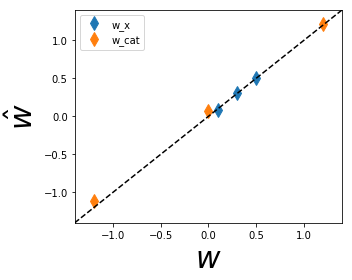

In [18]:
f,axarr = plt.subplots(1,figsize=[5,4])
ax = axarr
ax.plot([0.3,0.5,0.1],w_x[0],'d',ms=10)
ax.plot([-1.2,0,1.2],w_cat[0],'d',ms=10)
ax.plot([-1.4,1.4],[-1.4,1.4],'k--')
ax.axis([-1.4,1.4,-1.4,1.4])
ax.set_ylabel(r'$\hat{w}$',fontsize=30)
ax.set_xlabel(r'$w$',fontsize=30)
ax.legend(['w_x','w_cat'],loc=2,numpoints=1)
plt.tight_layout()
plt.show()

## Keras
Keras is one of the most popular and powerful TensorFlow extension libraries. In 2017 Keras gained official Google support, and will be moved into tf.contrib in the near future.

Keras has two main types of models to choose —Sequential and functional. The sequential type is designed for simple architectures, where we just want to stack layers in a linear fashion. The functional API can support more general models with a diverse layer structure such as multi-output models or a directed acyclic graph. 

# Installation

~~~python 
pip install keras
~~~

Or download from:
[Git page](https://github.com/fchollet/keras)

And install using:

~~~python 
python setup.py install
~~~


# Sequential model



### Dense layer
Dense" is a fully connected layer where the first argument denotes the number of output units and the input shape is the shape of the input (in this example the weight matrix would be of size 784x64). 



~~~python 
from keras.models import Sequential
from keras.layers import Dense, Activation 

model = Sequential()

model.add(Dense(units=64, input_dim=784))
model.add(Activation('softmax')~~~


Learning configurations are using 
~~~python 
.complie() 
~~~
It receives three arguments: the loss function, optimizer and another metric function that is used to judge the performance of your model.

~~~python 
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])~~~

set the optimizer

~~~python 
optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.8, nesterov=True))
~~~

And finally we feed .fit() the data and set the number of epochs and batch_size. As with the previous libraries, we can now easily evaluate how it does and perform prediction with new test data.

Note that a "callbacks" argument was added to the fit method. Callbacks are functions that are a applied during the training procedure, and we can use them to get a view on statistics and make dynamic training decisions by passing a list of them to the ,fit() method.

In this example we plug in two callbacks: (1) TensorBoard, specifying its output folder, and (2) early stopping, where we specify the minimum changed to be monitored (min_delta), the number of no-improvement epochs to stop after (patience) and the direction of wanted change (mode), set here to be inferred automatically.

~~~python 
from keras.callbacks import TensorBoard,EarlyStopping,ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

model.fit(x_train, y_train, epochs=10, batch_size=64,
          callbacks=[TensorBoard(log_dir='/models/autoencoder',)
          early_stop])

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
classes = model.predict(x_test, batch_size=64)
~~~



# Functional model
The main difference here is that we first define our input and output, and only then instantiate the model

Create an input Tensor according to its shape

~~~python 
inputs = Input(shape=(784,))
~~~

Define model

~~~python 
x = Dense(64, activation='relu')(inputs)
x = Dense(32, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)
~~~

And now instantiate the model, passing both inputs and outputs to "Model".

~~~python 
model = Model(inputs=inputs, oprintutputs=outputs)

from keras.callbacks import TensorBoard,EarlyStopping,ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

model.fit(x_train, y_train, epochs=10, batch_size=64,
          callbacks=[TensorBoard(log_dir='/models/autoencoder',)
          early_stop])

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
classes = model.predict(x_test, batch_size=64)
~~~

# Autoencoders
Output a reconstruction of the input after having its dimensionality reduced in the process

Autoencoders create a bottleneck layer, called a hidden layer that has a smaller number of units than the input layer, forcing the data to be compressed before reconstructed. For the reconstruction (decoding) to be done efficiently, autoencoders extract representative features that capture some hidden abstraction.

<img src="./img/autoencoders2.png" width="800">

In [2]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Dense
from keras.models import Model
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


First we load the images using keras, and then choose only the images that correspond to label '1' (Automobile
).

Next we do a little preprocessing, first by converting our data to float32 and and normalize it to range between [0,1]. 

In [3]:
x_train = x_train[np.where(y_train==1)[0],:,:,:]
x_test = x_test[np.where(y_test==1)[0],:,:,:]

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

Then we add some Gaussian noise, and clip values that are either smaller than 0 or larger than 1.

In [4]:
x_train_n = x_train + 0.5 * np.random.normal(loc=0.0, scale=0.4, size=x_train.shape) 
x_test_n = x_test + 0.5 * np.random.normal(loc=0.0, scale=0.4, size=x_test.shape) 

x_train_n = np.clip(x_train_n, 0., 1.)
x_test_n = np.clip(x_test_n, 0., 1.)

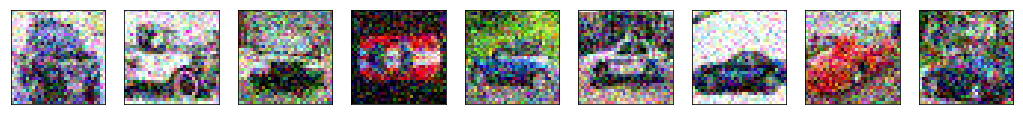

In [5]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_n[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We declare the input layer (every image in CIFAR is 32x32 pixels with RGB channels)



In [6]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model
inp_img = Input(shape=(32, 32, 3))  

Our first layer is a 2D convolution layer, where the first argument is the number of filters (and thus the number of output images), and the second is the size of each filter.   

In [7]:
img= Conv2D(32, (3, 3), activation='relu', padding='same')(inp_img)

Next, we add more "legos" layers: we add a 2x2 pooling layer , another convolution layer, an up-sampling (repeating the rows and columns of the data to get back the same number of pixels in each image), and finally a convolutional output layer where we go back to 3 channels. 

In [8]:
img = MaxPooling2D((2, 2), padding='same')(img)
# img = Dropout(0.25)(img)

img = Conv2D(32, (3, 3), activation='relu', padding='same')(img)
img = UpSampling2D((2, 2))(img)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(img)

We declare the functional model format, passing both inputs and ouputs. 



In [9]:
autoencoder = Model(inp_img, decoded)

We compile the model, declaring the loss function and the optimizer, in this case the Adagrad optimizer. 

In [10]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [11]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint

tensorboard = TensorBoard(log_dir='./models/autoencoder', histogram_freq=0,  
          write_graph=True, write_images=True)
model_saver = ModelCheckpoint(filepath='./models/autoencoder/autoencoder_model',verbose=0,period=2)


autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[tensorboard,model_saver])

Train on 5000 samples, validate on 1000 samples
Epoch 1/10
5000/5000 [==============================] - 17s - loss: 0.6342 - val_loss: 0.5675
Epoch 2/10
5000/5000 [==============================] - 15s - loss: 0.5666 - val_loss: 0.5545
Epoch 3/10
5000/5000 [==============================] - 15s - loss: 0.5546 - val_loss: 0.5524
Epoch 4/10
5000/5000 [==============================] - 15s - loss: 0.5502 - val_loss: 0.5444
Epoch 5/10
5000/5000 [==============================] - 15s - loss: 0.5470 - val_loss: 0.5476
Epoch 6/10
5000/5000 [==============================] - 15s - loss: 0.5444 - val_loss: 0.5384
Epoch 7/10
5000/5000 [==============================] - 15s - loss: 0.5424 - val_loss: 0.5420
Epoch 8/10
5000/5000 [==============================] - 15s - loss: 0.5405 - val_loss: 0.5393
Epoch 9/10
5000/5000 [==============================] - 15s - loss: 0.5391 - val_loss: 0.5364
Epoch 10/10
5000/5000 [==============================] - 15s - loss: 0.5380 - val_loss: 0.5360


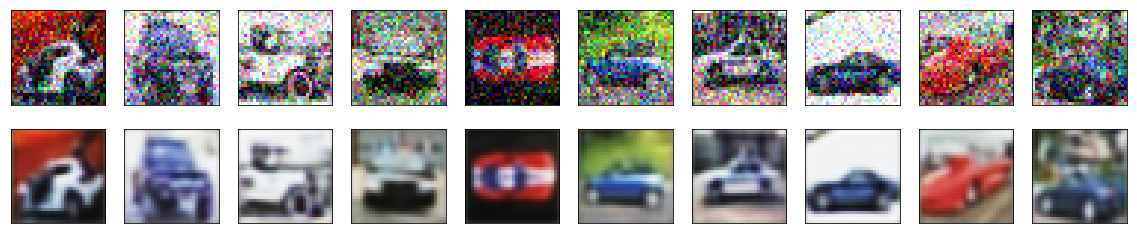

In [13]:
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(x_test)
n_imgs = 10
f,axarr = plt.subplots(2,n_imgs,figsize=[20,4])
for i in range(n_imgs):
    ax = axarr[0,i]
    ax.imshow(x_test_n[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = axarr[1,i]
    ax.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
from keras.layers import LSTM, Dropout
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam


model = Sequential()

rnn_size = 64 # The number of neurons in hidden layers.

window_size = 20 # The number of previous notes (and rests) to use as input to the network 
#at each step (measured in 16th notes). It is helpful to think of this as 
#the fixed width of a piano roll rather than individual events.

OUTPUT_SIZE = 129 # 0-127 notes + 1 for rests

dropout = 0.2 # The normalized percentage (0-1) of weights to randomly turn "off" 
# in each layer during a training step. This is a regularization technique called which helps 
# prevent model overfitting. Recommended values are between 0.2 and 0.5, or 20% and 50%.


learning_rate = 0.5 

grad_clip = 5.0 # Clip backpropagated gradients to this value.


kwargs = dict() 
kwargs['units'] = rnn_size
kwargs['input_shape'] = (window_size, OUTPUT_SIZE)

kwargs['return_sequences'] = True
model.add(LSTM(**kwargs))

model.add(LSTM(**kwargs))
model.add(Dropout(dropout))
kwargs['return_sequences'] = True

    
model.add(LSTM(**kwargs))
model.add(Dropout(dropout))
kwargs['return_sequences'] = False

model.add(Dense(OUTPUT_SIZE))
model.add(Activation('softmax'))    

kwargs = { 'clipvalue': grad_clip }

kwargs['lr'] = learning_rate

optimizer = Adam(**kwargs)

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer,
              metrics=['accuracy'])

print(model.summary())


# load pitch sequences in one-hot encoding

model.fit(x_train, y_train, epochs=10, batch_size=64)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 20, 64)            49664     
_________________________________________________________________
lstm_20 (LSTM)               (None, 20, 64)            33024     
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 64)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 20, 64)            33024     
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 64)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 20, 129)           8385      
_________________________________________________________________
activation_6 (Activation)    (None, 20, 129)           0         
Total para

In [ ]:
batch_size = 32 # The number of samples to pass through the network before updating weights.

n_jobs = 1 #The number of CPU cores to use when loading and parsing MIDI files from --data_dir. Increasing this value can dramatically speed up training. I commonly set this value to use all cores, which for my quad-core machine is 8 (Intel CPUs often have 2 virtual cores per CPU).

max_files_in_ram = 25 # Files in --data_dir are loaded into RAM in small batches, processed, and then released to avoid having to load all training files into memory at once (which may be impossible when training on hundreds of files on a machine with limited memory). This value specifies the maximum number of MIDI files to keep in RAM at any one time. Using a larger number significantly speeds up training, however it also runs the risk of using too much RAM and causing your machine to start thrashing or crash. You can find a nice balance by inspecting your system monitor (Activity Monitor on MacOS and Monitor on Ubuntu) while training and adjust accourdingly.

num_epochs = 10 # The number of epochs before completing training. One epoch is equal to one full pass through all midi files




val_split = 0.2 # use 20 percent for validation
val_split_index = int(float(len(midi_files)) * val_split)

# use generators to lazy load train/validation data, ensuring that the
# user doesn't have to load all midi files into RAM at once
train_generator = utils.get_data_generator(midi_files[0:val_split_index], 
                                           window_size=window_size,
                                           batch_size=batch_size,
                                           num_threads=n_jobs,
                                           max_files_in_ram=max_files_in_ram)







val_generator = utils.get_data_generator(midi_files[val_split_index:], 
                                         window_size=args.window_size,
                                         batch_size=args.batch_size,
                                         num_threads=args.n_jobs,
                                         max_files_in_ram=args.max_files_in_ram)




# callbacks = get_callbacks(experiment_dir)

print('fitting model...')
# this is a somewhat magic number which is the average number of length-20 windows
# calculated from ~5K MIDI files from the Lakh MIDI Dataset.
magic_number = 827

start_time = time.time()
model.fit_generator(train_generator,
                    steps_per_epoch=len(midi_files) * magic_number / args.batch_size, 
                    epochs=args.num_epochs,
                    validation_data=val_generator, 
                    validation_steps=len(midi_files) * 0.2 * magic_number / args.batch_size,
                    verbose=1, 
                    initial_epoch=epoch)

print('Finished in {:.2f} seconds'.format(time.time() - start_time))

In [ ]:
def get_data_generator(midi_paths, 
                       window_size=20, 
                       batch_size=32,
                       num_threads=8,
                       max_files_in_ram=170):

    if num_threads > 1:
    	# load midi data
    	pool = ThreadPool(num_threads)

    load_index = 0

    while True:
        load_files = midi_paths[load_index:load_index + max_files_in_ram]
        # print('length of load files: {}'.format(len(load_files)))
        load_index = (load_index + max_files_in_ram) % len(midi_paths)

        # print('loading large batch: {}'.format(max_files_in_ram))
        # print('Parsing midi files...')
        # start_time = time.time()
        if num_threads > 1:
       		parsed = pool.map(parse_midi, load_files)
       	else:
       		parsed = map(parse_midi, load_files)
        # print('Finished in {:.2f} seconds'.format(time.time() - start_time))
        # print('parsed, now extracting data')
        data = _windows_from_monophonic_instruments(parsed, window_size)
        batch_index = 0
        while batch_index + batch_size < len(data[0]):
            # print('getting data...')
            # print('yielding small batch: {}'.format(batch_size))
            
            res = (data[0][batch_index: batch_index + batch_size], 
                   data[1][batch_index: batch_index + batch_size])
            yield res
            batch_index = batch_index + batch_size
        
        # probably unneeded but why not
        del parsed # free the mem
        del data # free the mem

